In [2]:
%%capture
!uv pip install s3fs zarr cftime

*Workshop 4. Doing research with hydrological data*


# Case study 3: Estimating flooding

## Objectives:
-
-

In this case study, we will be examining river flow data from the National River Flow Archive [NRFA](https://nrfa.ceh.ac.uk/)

In [ ]:
# Load required libraries
import fsspec
import s3fs
import zarr
import xarray as xr

# 1. Load in data

**Data sources:**
- gridded rain over Severn - object-store
- Severn sub-catchment boundaries and river flow - NRFA (manual download)
- *maybe* Rivers - OpenRivers
- River projections - object-store


<xarray.Dataset> Size: 100GB
Dimensions:  (y: 1057, x: 656, time: 36000)
Coordinates:
  * time     (time) object 288kB 1980-12-01 12:00:00 ... 2080-11-30 12:00:00
  * x        (x) float32 3kB 500.0 1.5e+03 2.5e+03 ... 6.545e+05 6.555e+05
  * y        (y) float32 4kB 500.0 1.5e+03 2.5e+03 ... 1.056e+06 1.056e+06
Data variables:
    lat      (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    tasmax   (time, y, x) float32 100GB dask.array<chunksize=(360, 100, 100), meta=np.ndarray>
    lon      (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    NCO:          4.7.3
    contact:      emrobi@ceh.ac.uk
    history:      Fri Mar 19 15:18:41 2021: cdo --sortname -add /gws/nopw/j04...
    institution:  CEH Wallingford - NERC
    project:      UK-SCAPE: SPEED

## 1.3 Load spatial datasets for Upper Severn catchment
Finally, we download some spatial data for the River Severn, including catchment boundaries from the NRFA, and watercourse data from Ordinance Survey.

Data originally downloaded from: [NRFA](https://nrfa.ceh.ac.uk/data/search) & [Ordinance Survey](https://www.ordnancesurvey.co.uk/products/os-open-rivers)

This bash script below will fetch and download spatial data from GitHub and store it locally in the folder 'severn_catchment_data'

In [ ]:
%%capture
# !wget -O https://github.com/Thomasjkeel/UKCEH_Summer_School_2025/blob/edit/workshop-3/Workshop_4/severn_catchment_data.tar.gz
!mkdir -p severn_catchment_data
!tar -xvf severn_catchment_data.tar.gz -C severn_catchment_data

Load shapefiles & geojson using geopandas

In [ ]:
# Greater Severn catchment boundary
bewdley_shp = gpd.read_file("severn_catchment_data/Bewdley/54001/54001.shp")

# Upper Severn catchment boundaries
abermule_shp = gpd.read_file("severn_catchment_data/Abermule/54014/54014.shp")
dolwen_shp = gpd.read_file("severn_catchment_data/Dolwen/54080/54080.shp")
plynlimon_shp = gpd.read_file("severn_catchment_data/Plynlimon Flume/54022/54022.shp")

In [12]:
# Load rivers linestrings
severn_catchment_river_linestrings = gpd.read_file(
    "severn_catchment_data/rivers_around_severn.geojson"
)
severn_river_linestrings = severn_catchment_river_linestrings.loc[
    severn_catchment_river_linestrings["name1"].str.contains("River Severn")
]

Next, we plot the catchment boundaries and the River Severn

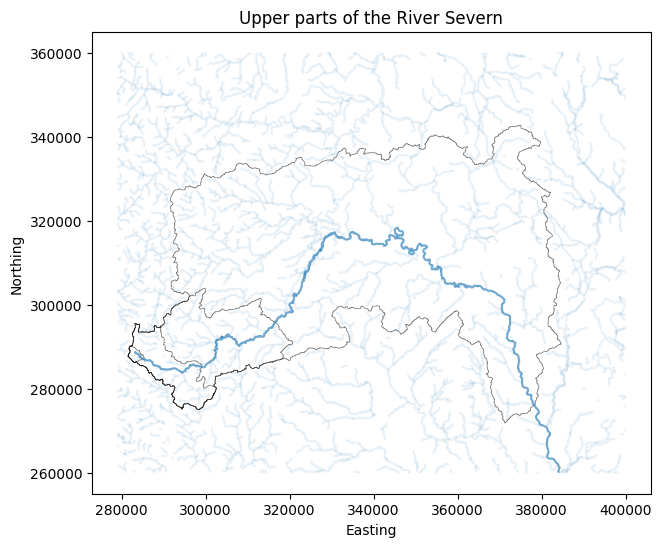

In [13]:
fig, ax = plt.subplots(1, figsize=(12, 6), sharex=True, sharey=True)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
abermule_shp.plot(ax=ax, facecolor="none", alpha=0.5, linewidth=0.5)
bewdley_shp.plot(ax=ax, facecolor="none", alpha=0.5, linewidth=0.5)
dolwen_shp.plot(ax=ax, facecolor="none", alpha=0.5, linewidth=0.5)
plynlimon_shp.plot(ax=ax, facecolor="none", alpha=0.5, linewidth=0.5)

severn_catchment_river_linestrings.plot(ax=ax, alpha=0.1)
severn_river_linestrings.plot(ax=ax, alpha=0.6)
ax.set_title("Upper parts of the River Severn")
plt.subplots_adjust(hspace=0.2)

We'll also load in some height data 

In [14]:
severn_hght = rioxarray.open_rasterio("severn_catchment_data/HGHT_SEVERN_1KM_CLIP.tif")
severn_hght = severn_hght.sortby("y")
severn_hght = severn_hght.sel(band=1)
severn_hght = severn_hght / 10  # divide by 10, so in metres
severn_hght = severn_hght.sel(
    x=slice(*SEVERN_EASTING_RANGE), y=slice(*SEVERN_NORTHING_RANGE)
)

Text(0.5, 1.0, 'Height profile of upper parts of the River Severn')

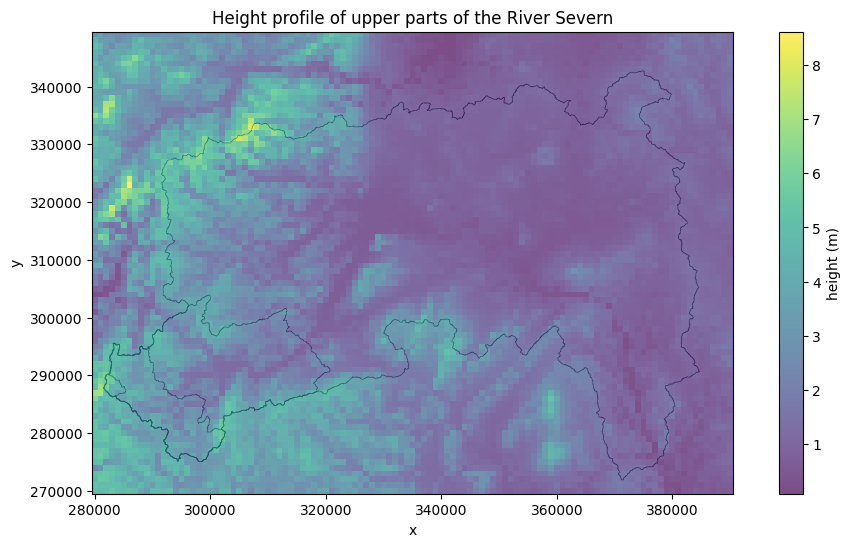

In [15]:
fig, ax = plt.subplots(1, figsize=(12, 6), sharex=True, sharey=True)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
abermule_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)
bewdley_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)
dolwen_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)
plynlimon_shp.plot(ax=ax, facecolor="none", alpha=0.8, linewidth=0.5)
severn_hght.plot(ax=ax, alpha=0.7, cbar_kwargs={"label": "height (m)"})

ax.set_title("Height profile of upper parts of the River Severn")

In [ ]:
fdri_fs = fsspec.filesystem(
    "s3", asynchronous=True, anon=True, endpoint_url="https://fdri-o.s3-ext.jc.rl.ac.uk"
)
gear_daily_zstore = zarr.storage.FsspecStore(
    fdri_fs, path="geardaily/GB/geardaily_fulloutput_yearly_100km_chunks.zarr"
)
gear_daily = xr.open_zarr(
    gear_daily_zstore, decode_times=True, decode_cf=True, consolidated=False
)
gear_daily

<xarray.Dataset> Size: 100GB
Dimensions:  (y: 1057, x: 656, time: 36000)
Coordinates:
  * x        (x) float32 3kB 500.0 1.5e+03 2.5e+03 ... 6.545e+05 6.555e+05
  * y        (y) float32 4kB 500.0 1.5e+03 2.5e+03 ... 1.056e+06 1.056e+06
  * time     (time) object 288kB 1980-12-01 12:00:00 ... 2080-11-30 12:00:00
Data variables:
    lat      (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon      (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    tasmax   (time, y, x) float32 100GB dask.array<chunksize=(360, 100, 100), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    NCO:          4.7.3
    contact:      emrobi@ceh.ac.uk
    history:      Fri Mar 19 15:18:41 2021: cdo --sortname -add /gws/nopw/j04...
    institution:  CEH Wallingford - NERC
    project:      UK-SCAPE: SPEED

#### 🤨 Tasks

???
Replace the ??? below with your answer

# 2. Format data

#### 🤨 Tasks

???
Replace the ??? below with your answer

# 3. Compute high- and low-flow events

In [ ]:
def compute_flood_event_dates(gdf_data, q=0.95):
    q95 = gdf_data["gdf"].quantile(q)
    return pyextremes.get_extremes(
        gdf_data.set_index("date")["gdf"], "POT", threshold=q95
    ).index

In [ ]:
bewdley_flood = compute_flood_event_dates(bewdley_gdf, q=0.95)
buildwas_flood = compute_flood_event_dates(buildwas_gdf, q=0.95)
montford_flood = compute_flood_event_dates(montford_gdf, q=0.95)

len(bewdley_flood), len(buildwas_flood), len(montford_flood)

In [ ]:
montford_bewdley_floods = set(montford_flood).intersection(set(bewdley_flood))
severn_floods = montford_bewdley_floods.intersection(set(buildwas_flood))
print(f"Total of {len(severn_floods)} flood events co-occuring across the catchments")

#### 🤨 Tasks

???
Replace the ??? below with your answer

# 4. Compare flow to rainfall

In [ ]:
def mask_region_rainfall_by_hght(rainfall_data, region_hght, threshold):
    region_hght_mask = region_hght / region_hght.where(region_hght > threshold)
    return rainfall_data * region_hght_mask.data

## ❗❗ FURTHER TASKS ❗❗  
Feel free to stop at this point, but below are some additional and more advanced topics and tasks requiring more of your own input.

- Flood frequency analysis
- Low-flow events

## Extra task: using Chess Scape future temperatures

In [10]:
# We are accessing TASMAX & PRCPT for the Ensemble member #01 from the catalogue
fs = fsspec.filesystem(
    "s3",
    asynchronous=True,
    anon=True,
    endpoint_url="https://chess-scape-o.s3-ext.jc.rl.ac.uk",
)
tmax_zstore = zarr.storage.FsspecStore(
    fs, path="ens01-year100kmchunk/tmax_01_year100km.zarr"
)
pr_zstore = zarr.storage.FsspecStore(
    fs, path="ens01-year100kmchunk/pr_01_year100km.zarr"
)

chess_tmax = xr.open_zarr(
    tmax_zstore, decode_times=True, decode_cf=True, consolidated=False
)
chess_pr = xr.open_zarr(
    pr_zstore, decode_times=True, decode_cf=True, consolidated=False
)

In [11]:
chess_pr

<xarray.Dataset> Size: 100GB
Dimensions:  (y: 1057, x: 656, time: 36000)
Coordinates:
  * x        (x) float32 3kB 500.0 1.5e+03 2.5e+03 ... 6.545e+05 6.555e+05
  * time     (time) object 288kB 1980-12-01 12:00:00 ... 2080-11-30 12:00:00
  * y        (y) float32 4kB 500.0 1.5e+03 2.5e+03 ... 1.056e+06 1.056e+06
Data variables:
    lat      (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    pr       (time, y, x) float32 100GB dask.array<chunksize=(360, 100, 100), meta=np.ndarray>
    lon      (y, x) float32 3MB dask.array<chunksize=(100, 100), meta=np.ndarray>
Attributes:
    NCO:            4.7.3
    contact:        emrobi@ceh.ac.uk
    institution:    CEH Wallingford - NERC
    normalisation:  bias corrected against historical CHESS data
    project:        UK-SCAPE: SPEED

# Additional Reading

- <https://github.com/NERC-CEH/FDRI-comparing-rainfall-data-in-upper-severn/tree/main>  

- <https://github.com/NERC-CEH/FDRI-high-altitude-rainfall-and-floods>